In [15]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import norm, beta

# 1. Coin tossing (Beta prior + Binomial likelihood)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


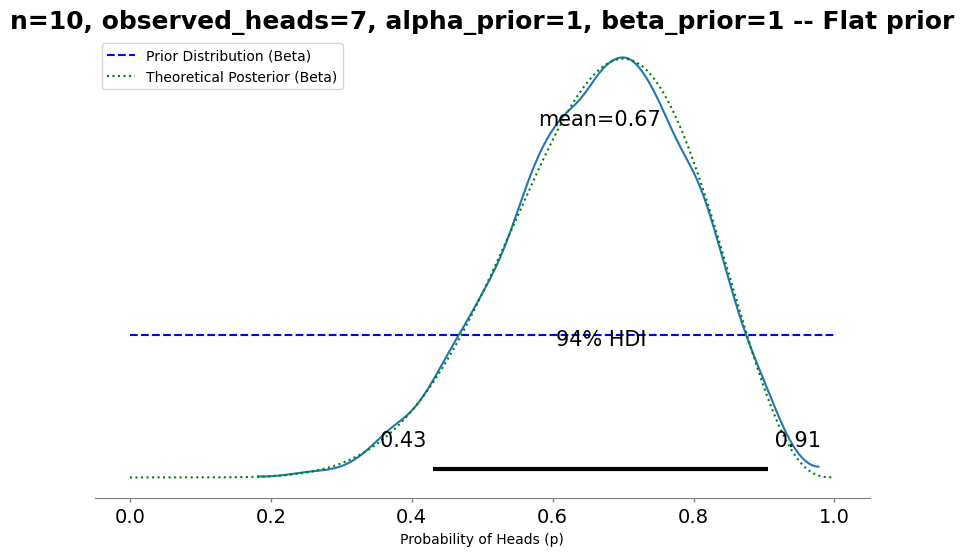

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


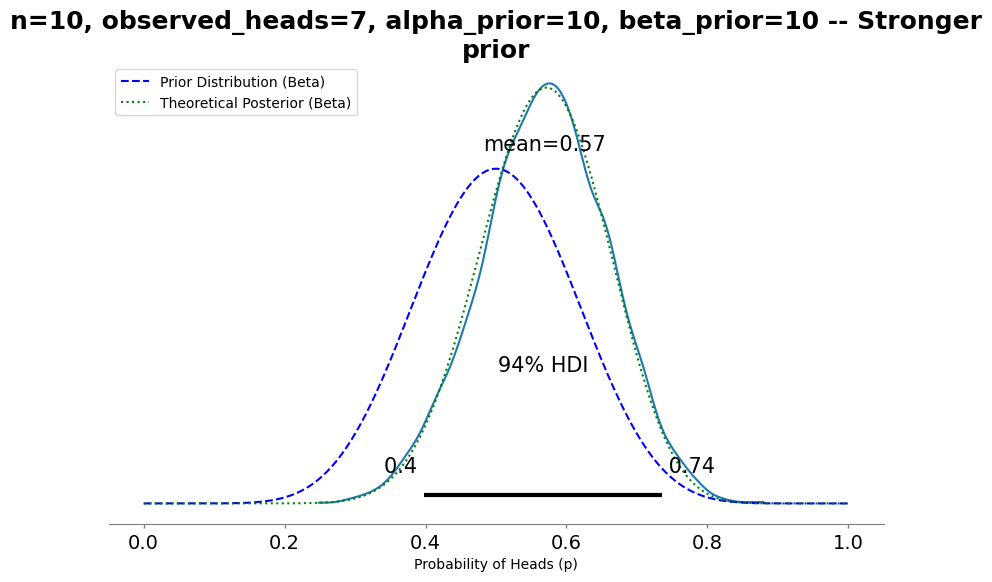

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


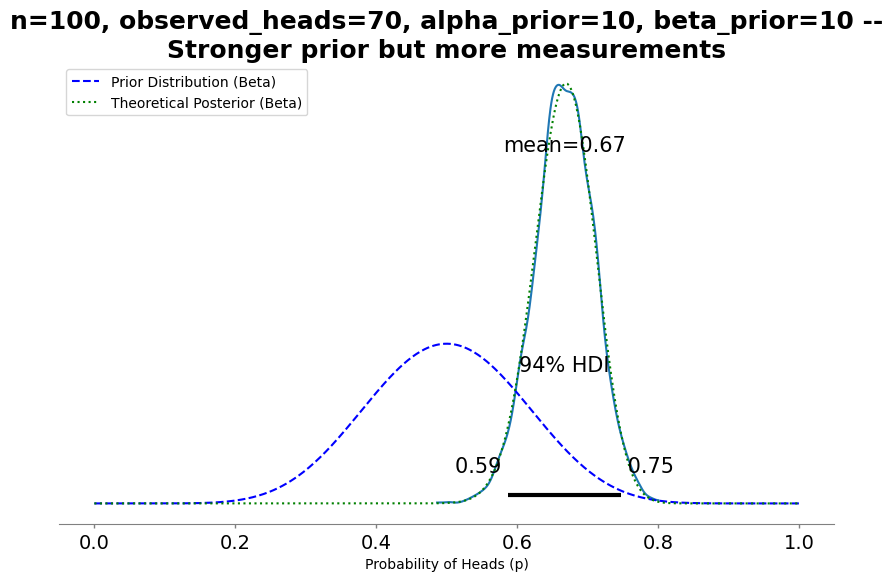

In [19]:
def run_coin_inference(n, observed_heads, alpha_prior, beta_prior, text):
    # Calculate theoretical posterior parameters
    alpha_post = alpha_prior + observed_heads
    beta_post = beta_prior + n - observed_heads

    # PyMC model
    with pm.Model() as model:
        # Prior for p with specified alpha and beta parameters
        p = pm.Beta("p", alpha=alpha_prior, beta=beta_prior)
        
        # Likelihood for observed data (heads count in n flips)
        heads_observed = pm.Binomial("heads_observed", n=n, p=p, observed=observed_heads)
        
        # Sample from the posterior
        trace = pm.sample(2000, return_inferencedata=True, progressbar=False)

    # Plot prior, posterior from sampling, and theoretical posterior
    fig, ax = plt.subplots(figsize=(10, 6))

    # Posterior plot from sampling
    az.plot_posterior(trace, var_names=["p"], ax=ax, hdi_prob=0.94)
    ax.set_title(f"n={n}, observed_heads={observed_heads}, alpha_prior={alpha_prior}, beta_prior={beta_prior} -- {text}", 
                              fontsize=18, fontweight='bold')
    ax.set_xlabel("Probability of Heads (p)")

    
    # Overlay the prior distribution for p
    x = np.linspace(0, 1, 500)
    prior_pdf = beta.pdf(x, alpha_prior, beta_prior)
    ax.plot(x, prior_pdf, label="Prior Distribution (Beta)", color="blue", linestyle="--")

    # Overlay the theoretical posterior distribution
    posterior_pdf = beta.pdf(x, alpha_post, beta_post)
    ax.plot(x, posterior_pdf, label="Theoretical Posterior (Beta)", color="green", linestyle=":")

    # Display legend
    ax.legend(loc="upper left")
    plt.show()

# Parameters to compare
parameter_sets = [
    {"n": 10, "observed_heads": 7, "alpha_prior": 1, "beta_prior": 1, "text": "Flat prior"},
    {"n": 10, "observed_heads": 7, "alpha_prior": 10, "beta_prior": 10, "text": "Stronger prior"},
    {"n": 100, "observed_heads": 70, "alpha_prior": 10, "beta_prior": 10, "text": "Stronger prior but more measurements"},
]

# Run the model with different parameter sets
for params in parameter_sets:
    run_coin_inference(**params)


# 2. Measurement with Normal error (Normal prior + Normal likelihood)

In [23]:
def run_bayesian_inference_normal(n, true_theta, sigma_prior, sigma_x, step=None, text=None):
    np.random.seed(41)  # for reproducibility
    observations = np.random.normal(true_theta, sigma_x, size=n) # Simulate observed data based on true theta

    # Calculate theoretical posterior parameters
    prior_mean = 0  # Prior mean for Theta
    prior_var = sigma_prior ** 2
    likelihood_var = sigma_x ** 2 # assume all measurements have the same sigma

    posterior_var = 1 / (1 / prior_var + n / likelihood_var)
    posterior_std = np.sqrt(posterior_var)
    posterior_mean = (prior_mean / prior_var + np.sum(observations) / likelihood_var) * posterior_var    

    # PyMC model -- Here we do the Bayes "magic"
    # This part does not see true_theta, it only infers about it from observations
    with pm.Model() as model:
        # Prior for Theta with specified prior standard deviation
        theta = pm.Normal("theta", mu=prior_mean, sigma=sigma_prior)
        
        # Likelihood for observed data given Theta
        x_obs = pm.Normal("x_obs", mu=theta, sigma=sigma_x, observed=observations)
        
        # Sample from the posterior 
        if step=="met": # We use the Metropolis-Hastings method "original MCMC"
            trace = pm.sample(2000, step=pm.Metropolis(), return_inferencedata=True, progressbar=False)
        else: # otherwise we use the default the more recent method "hamiltonian MCMC" 
            trace = pm.sample(2000, return_inferencedata=True, progressbar=False)

    # The rest is image creation
    # Plot posterior with prior, observations, and theoretical posterior
    fig, ax = plt.subplots(figsize=(10, 6))

    # Posterior plot for theta
    az.plot_posterior(trace, var_names=["theta"], ax=ax, hdi_prob=0.94)
    ax.set_title(f"n={n}, sigma_prior={sigma_prior}, sigma_x={sigma_x}, data_mean={observations.mean():.1f} -- {text}", 
                                  fontsize=18, fontweight='bold')
    ax.set_xlabel("Theta")

    # Overlay the observations as a rug plot on the x-axis
    ax.plot(observations, np.full_like(observations, -0.01), '|', color='red', label="Observations", markersize=10)

    # Overlay the prior distribution for Theta
    x = np.linspace(-10, 20, 500)
    prior_pdf = norm.pdf(x, loc=prior_mean, scale=sigma_prior)
    ax.plot(x, prior_pdf, label="Prior Distribution (Normal)", color="blue", linestyle="--")

    # Overlay the theoretical posterior distribution
    posterior_pdf = norm.pdf(x, loc=posterior_mean, scale=posterior_std)
    ax.plot(x, posterior_pdf, label="Theoretical Posterior (Normal)", color="green", linestyle=":")

    # Display legend
    ax.legend(loc="upper left")
    plt.show()

## Nicer figures using the default, hamiltonian MCMC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


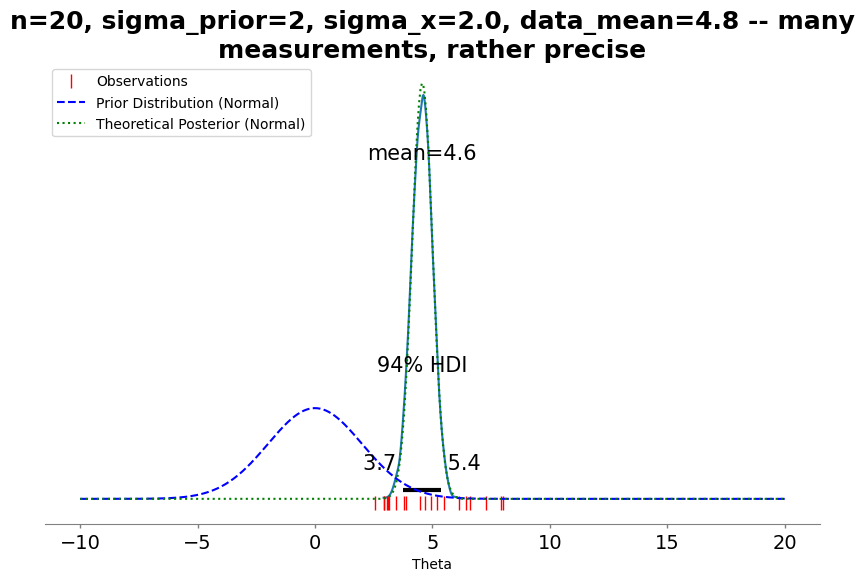

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


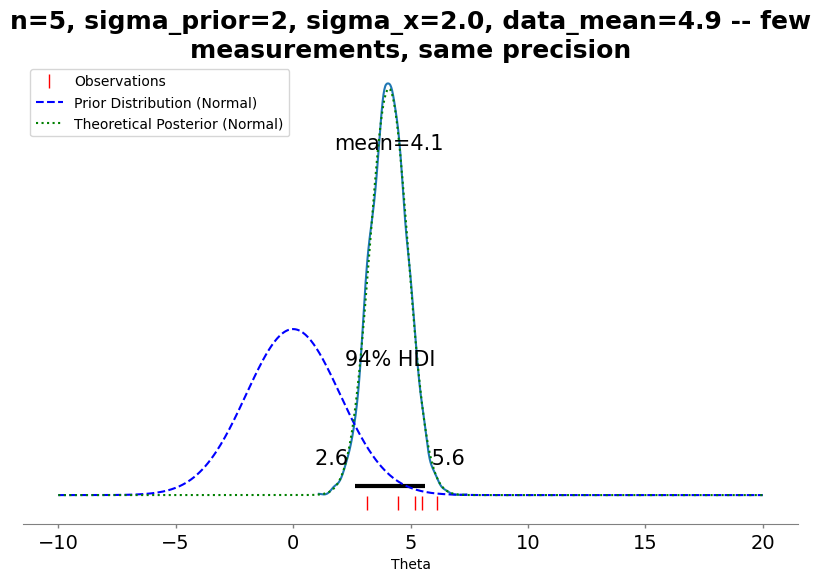

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


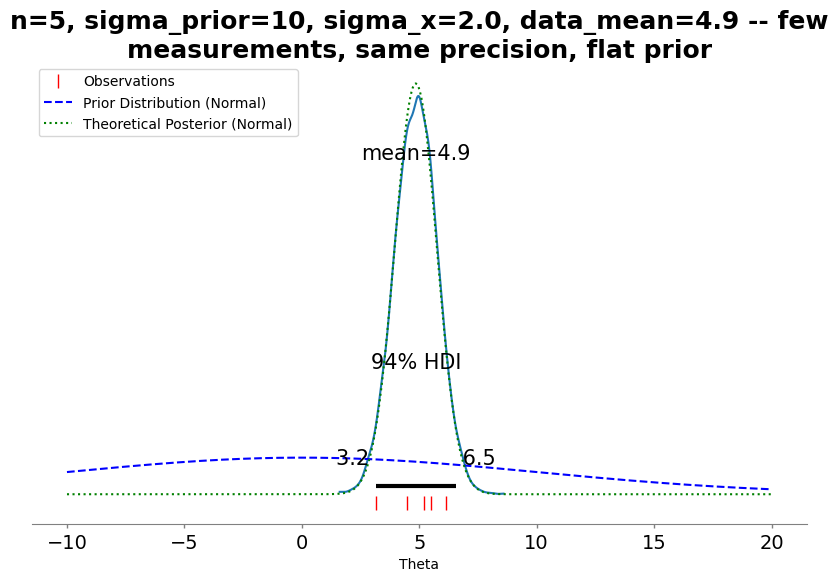

In [25]:
# Parameters to compare
parameter_sets = [
    {"n": 20, "true_theta": 5.0, "sigma_prior": 2, "sigma_x": 2.0, "text": "many measurements, rather precise"}, 
    {"n": 5, "true_theta": 5.0, "sigma_prior": 2, "sigma_x": 2.0, "text": "few measurements, same precision"}, 
    {"n": 5, "true_theta": 5.0, "sigma_prior": 10, "sigma_x": 2.0, "text": "few measurements, same precision, flat prior"}, 
]

# Run the model with different parameter sets
for params in parameter_sets:
    run_bayesian_inference_normal(**params)

## Same computation using Metropolis-Hastings

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


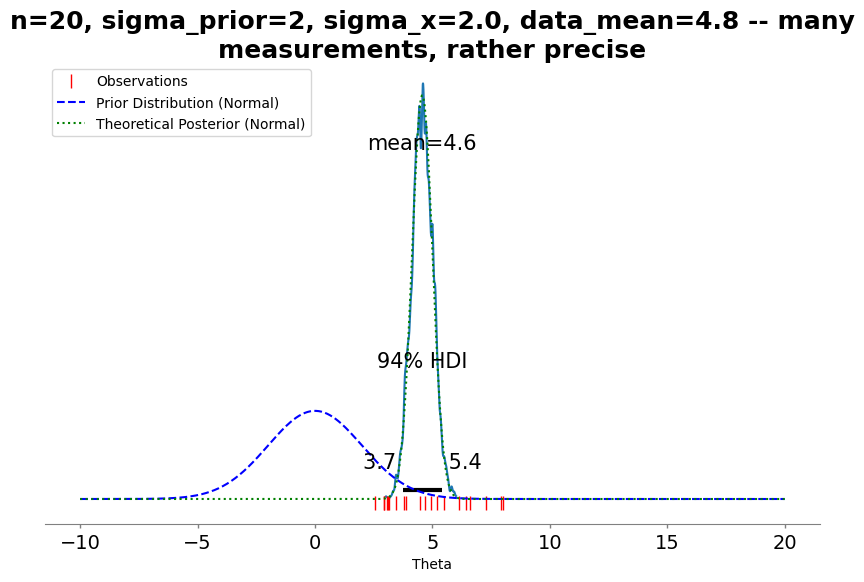

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


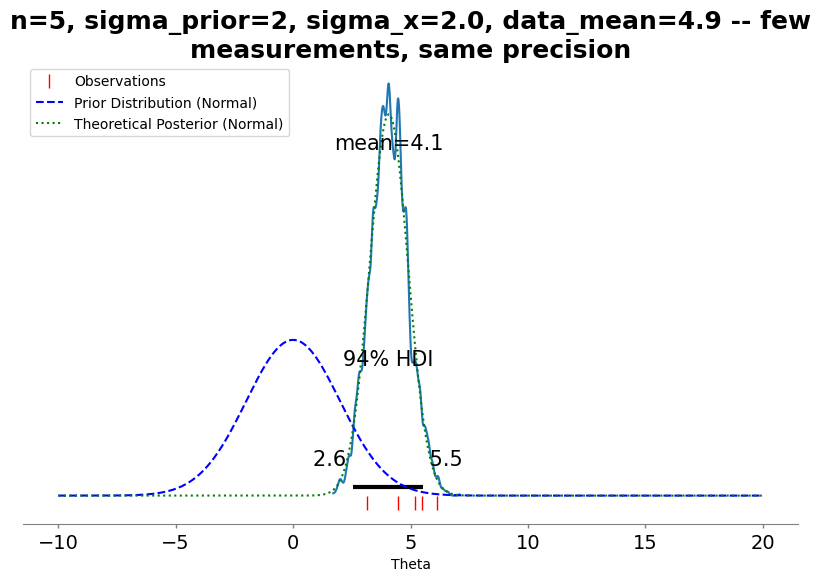

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


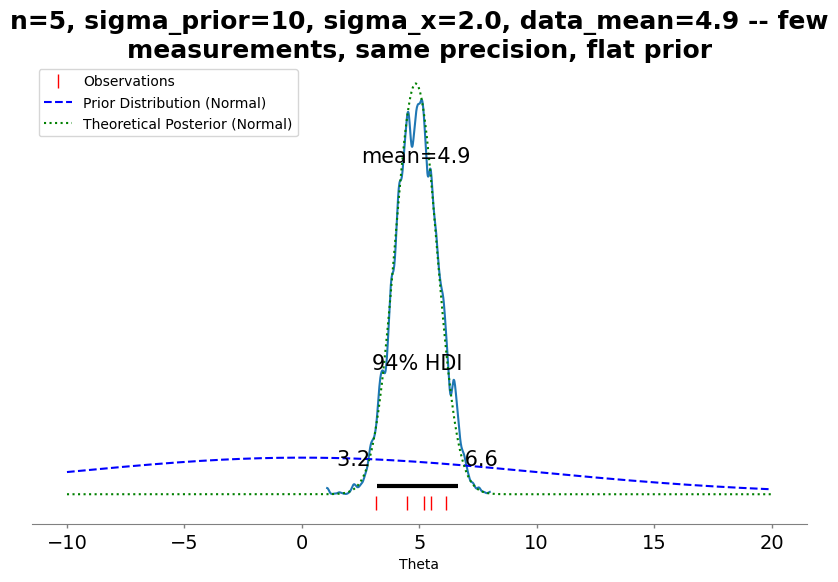

In [26]:
# Run the model with different parameter sets
for params in parameter_sets:
    run_bayesian_inference_normal(**params, step="met")